In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import itertools

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, GRU, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from datetime import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
df = pd.read_csv('Bhopal.csv')

In [3]:
print(df.describe().T)

                   count         mean         std      min      25%      50%  \
Year             87672.0  2017.417214    2.885936  2012.00  2015.00  2017.00   
Month            87672.0     6.525048    3.449271     1.00     4.00     7.00   
Day              87672.0    15.723846    8.801451     1.00     8.00    16.00   
Hour             87672.0    11.500000    6.922226     0.00     5.75    11.50   
Minute           87672.0     0.000000    0.000000     0.00     0.00     0.00   
Clearsky GHI     87672.0   252.270612  329.461913  -999.00     0.00     9.08   
Clearness Index  87672.0  -478.058489  499.301437  -999.00  -999.00     0.16   
Temperature 2m   87672.0    25.161487    7.670626     1.96    20.55    25.33   
GHI              87672.0   209.925902  288.371422  -999.00     0.00    10.13   

                       75%      max  
Year             2020.0000  2022.00  
Month              10.0000    12.00  
Day                23.0000    31.00  
Hour               17.2500    23.00  
Minute   

#Preprocessing

basic preprocessing
1. GHI>150
2. Groupby means over each day
3. set date as index

In [4]:
df['datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']])
df = df[df['GHI'] >= 150]

df['date'] = df['datetime'].dt.date
averages = df.groupby('date')['GHI'].mean().reset_index()

# We only need the 'date' and 'GHI' columns, and we'll reset the index to use 'date' as the index
final_df = averages[['date', 'GHI']].set_index('date')

<ipython-input-4-11902f6f97a0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


slicing data based on date

In [5]:
range_filter = datetime.strptime('2016-12-01', '%Y-%m-%d').date()
ghi_f = final_df.loc[final_df.index >= range_filter]
print(ghi_f.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2186 entries, 2016-12-01 to 2022-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GHI     2186 non-null   float64
dtypes: float64(1)
memory usage: 34.2+ KB
None


sectioning into different dataframes

In [6]:
len(ghi_f)

2186

This is the correct code: without overlap

In [7]:
train_test_ratio = 0.2  # 80% for train, 20% for test
train_df, test_df = train_test_split(ghi_f, test_size=train_test_ratio, shuffle=False)

Incorrect code: with overlap

In [8]:
#ensure splitting happens correctly
print(train_df.tail())
print(test_df.head())

                   GHI
date                  
2021-09-12  538.806667
2021-09-13  456.254000
2021-09-14  431.592000
2021-09-15  334.231111
2021-09-16  409.237500
                   GHI
date                  
2021-09-17  346.417500
2021-09-18  260.037500
2021-09-19  397.096250
2021-09-20  420.105556
2021-09-21  447.128750


In [9]:
print(len(train_df))
print(len(test_df))

1748
438


scaling all three datasets

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

#scaling values for faster model training
df_for_training_scaled = scaler.fit_transform(train_df)
df_for_test_scaled = scaler.fit_transform(test_df)

print(*df_for_training_scaled[:5])
print(*df_for_test_scaled[:5])

[0.54065176] [0.53970865] [0.48347948] [0.50463899] [0.58743964]
[0.29566632] [0.13589546] [0.38940315] [0.4319618] [0.48194466]


restructuring data to be a 3d array with (samples x timesteps x features)

> in time series prediction this will be (old data, window length, features=1)

In [11]:
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 30 # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training_scaled.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (1718, 30, 1).
trainY shape == (1718, 1).


In [12]:
testX = []
testY = []

for i in range(n_past, len(test_df) - n_future +1):
    testX.append(df_for_test_scaled[i - n_past:i, 0:df_for_test_scaled.shape[1]])
    testY.append(df_for_test_scaled[i + n_future - 1:i + n_future, 0])

testX, testY = np.array(testX), np.array(testY)

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

testX shape == (408, 30, 1).
testY shape == (408, 1).


#Build base model

In [13]:
model = Sequential()
model.add(LSTM(units=16, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=16, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 16)            1152      
                                                                 
 dropout (Dropout)           (None, 30, 16)            0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 3281 (12.82 KB)
Trainable params: 3281 (12.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# fit model
history = model.fit(trainX, trainY, validation_split=0.3, epochs=40, batch_size=64, callbacks=[es])

Epoch 1/40
19/19 [==============================] - 8s 77ms/step - loss: 0.0901 - root_mean_squared_error: 0.3002 - val_loss: 0.0359 - val_root_mean_squared_error: 0.1896
Epoch 2/40
19/19 [==============================] - 0s 18ms/step - loss: 0.0373 - root_mean_squared_error: 0.1932 - val_loss: 0.0269 - val_root_mean_squared_error: 0.1639
Epoch 3/40
19/19 [==============================] - 0s 13ms/step - loss: 0.0299 - root_mean_squared_error: 0.1729 - val_loss: 0.0269 - val_root_mean_squared_error: 0.1642
Epoch 4/40
19/19 [==============================] - 0s 10ms/step - loss: 0.0317 - root_mean_squared_error: 0.1779 - val_loss: 0.0265 - val_root_mean_squared_error: 0.1627
Epoch 5/40
19/19 [==============================] - 0s 13ms/step - loss: 0.0286 - root_mean_squared_error: 0.1690 - val_loss: 0.0260 - val_root_mean_squared_error: 0.1612
Epoch 6/40
19/19 [==============================] - 0s 13ms/step - loss: 0.0292 - root_mean_squared_error: 0.1710 - val_loss: 0.0258 - val_root_m

In [15]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

initial results

In [16]:
results = model.evaluate(testX, testY)
print("test loss, test acc:", np.round(results, 4))

13/13 [==============================] - 0s 10ms/step - loss: 0.0207 - root_mean_squared_error: 0.1439
test loss, test acc: [0.0207 0.1439]


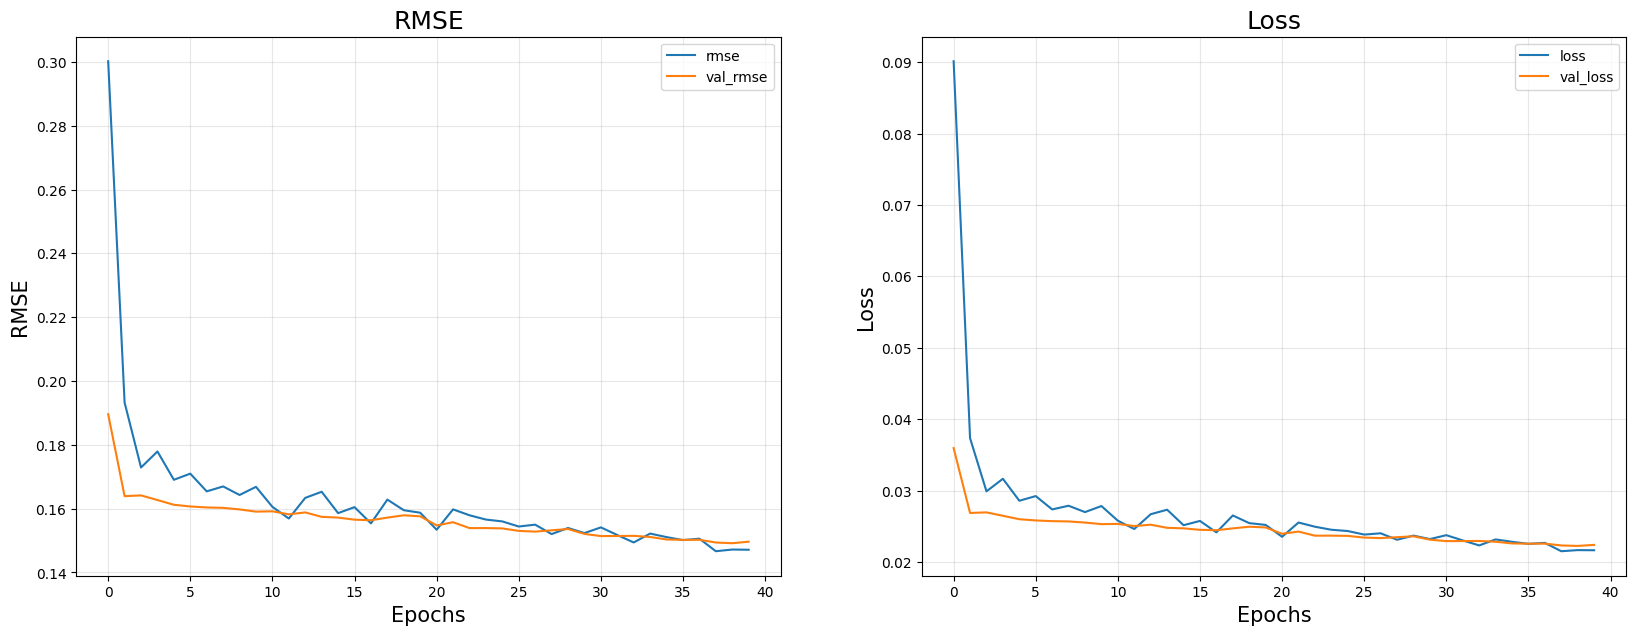

In [17]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)

# Accuracy
plt.plot(history.epoch, history.history['root_mean_squared_error'], label = "rmse")
plt.plot(history.epoch, history.history['val_root_mean_squared_error'], label = "val_rmse")

plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()


#Adding Subplot 1 (For Loss)
fig.add_subplot(122)

plt.plot(history.epoch, history.history['loss'], label="loss")
plt.plot(history.epoch, history.history['val_loss'], label="val_loss")

plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

#Post processing

In [18]:
def LSTM_HyperParameter_Tuning(config, trainX, trainY, testX, testY):

    first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = config
    possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout))

    print(f'possible combinations:{possible_combinations}')
    print('\n')

    hist = []

    for i in range(0, len(possible_combinations)):

        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')

        first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = possible_combinations[i]

        # instantiating the model in the strategy scope creates the model on the TPU
        #with tpu_strategy.scope():
        model = Sequential()
        model.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
        model.add(Dropout(dropout))

        if first_additional_layer:
            model.add(LSTM(units=n_neurons, return_sequences=True))
            model.add(Dropout(dropout))

        if second_additional_layer:
            model.add(LSTM(units=n_neurons, return_sequences=True))
            model.add(Dropout(dropout))

        if third_additional_layer:
            model.add(GRU(units=n_neurons, return_sequences=True))
            model.add(Dropout(dropout))

        model.add(LSTM(units=n_neurons, return_sequences=False))
        model.add(Dropout(dropout))
        model.add(Dense(units=1, activation='linear'))
        model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

        es = EarlyStopping(monitor='val_root_mean_squared_error', mode='min', verbose=1, patience=5)

        file_path = 'best_model.h5'

        mc = ModelCheckpoint(file_path, monitor='val_root_mean_squared_error', mode='min', verbose=1, save_best_only=True)

        model.fit(trainX, trainY, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)

        # load the best model
        # regressor = load_model('best_model.h5')

        train_accuracy = model.evaluate(trainX, trainY, verbose=0)
        test_accuracy = model.evaluate(testX, testY, verbose=0)

        hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout,
                          train_accuracy, test_accuracy)))

        print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')

        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')

    return hist

In [19]:
config = [[False], [False], [False], [16,32], [8, 32], [0.2]]

# list of lists --> [[first_additional_layer], [second_additional_layer], [third_additional_layer], [n_neurons], [n_batch_size], [dropout]]

hist = LSTM_HyperParameter_Tuning(config, trainX, trainY, testX, testY)  # change x_train shape

possible combinations:[(False, False, False, 16, 8, 0.2), (False, False, False, 16, 32, 0.2), (False, False, False, 32, 8, 0.2), (False, False, False, 32, 32, 0.2)]


1th combination: 

--------------------------------------------------------------------

Epoch 1: val_root_mean_squared_error improved from inf to 0.18046, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_root_mean_squared_error improved from 0.18046 to 0.16764, saving model to best_model.h5

Epoch 3: val_root_mean_squared_error improved from 0.16764 to 0.16012, saving model to best_model.h5

Epoch 4: val_root_mean_squared_error improved from 0.16012 to 0.15801, saving model to best_model.h5

Epoch 5: val_root_mean_squared_error did not improve from 0.15801

Epoch 6: val_root_mean_squared_error improved from 0.15801 to 0.15459, saving model to best_model.h5

Epoch 7: val_root_mean_squared_error improved from 0.15459 to 0.15297, saving model to best_model.h5

Epoch 8: val_root_mean_squared_error improved from 0.15297 to 0.15022, saving model to best_model.h5

Epoch 9: val_root_mean_squared_error improved from 0.15022 to 0.14880, saving model to best_model.h5

Epoch 10: val_root_mean_squared_error improved from 0.14880 to 0.14789, saving model to best_model.h5

Epoch 11: val_root_mean_squared_error did not improve from 0.14789

Epoch 12: val_root_mean_squared_error improved 

In [20]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist

,0,1,2,3,4,5,6,7
2,False,False,False,32,8,0.2,"[0.013600421138107777, 0.11662083864212036]","[0.015075725503265858, 0.12278324365615845]"
0,False,False,False,16,8,0.2,"[0.01383588183671236, 0.11762602627277374]","[0.015331388451159, 0.1238199844956398]"
3,False,False,False,32,32,0.2,"[0.01651950180530548, 0.12852820754051208]","[0.018287675455212593, 0.13523192703723907]"
1,False,False,False,16,32,0.2,"[0.016904521733522415, 0.13001738488674164]","[0.018849864602088928, 0.13729479908943176]"


In [21]:
print(f'Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}')
print('**************************')
print(f'Results Before Tuning:\n Test Set RMSE: {np.round(results, 4)[1]}\n Test Set Loss: {np.round(results, 4)[0]}\n')
print(f'Results After Tuning:\n Test Set RMSE: {np.round(hist.iloc[0, -1], 4)[1]}\n Test Set Loss: {np.round(hist.iloc[0, -1], 4)[0]}\n')
print(f'{np.round((results[1] - hist.iloc[0, -1][1])*100/np.round(results, 4)[1])}% Improvement in RMSE')
print(f'{np.round((results[1] - hist.iloc[0, -1][0])*100/np.round(results, 4)[0])}% Improvement in Loss')

Best Combination: 
 first_additional_layer = False
 second_additional_layer = False
 third_additional_layer = False
 n_neurons = 32
 n_batch_size = 8
 dropout = 0.2
**************************
Results Before Tuning:
 Test Set RMSE: 0.1439
 Test Set Loss: 0.0207

Results After Tuning:
 Test Set RMSE: 0.1228
 Test Set Loss: 0.0151

15.0% Improvement in RMSE
623.0% Improvement in Loss


In [22]:
model.evaluate(testX, testY)

13/13 [==============================] - 0s 4ms/step - loss: 0.0207 - root_mean_squared_error: 0.1439


[0.02071719989180565, 0.1439347118139267]

13/13 [==============================] - 1s 3ms/step


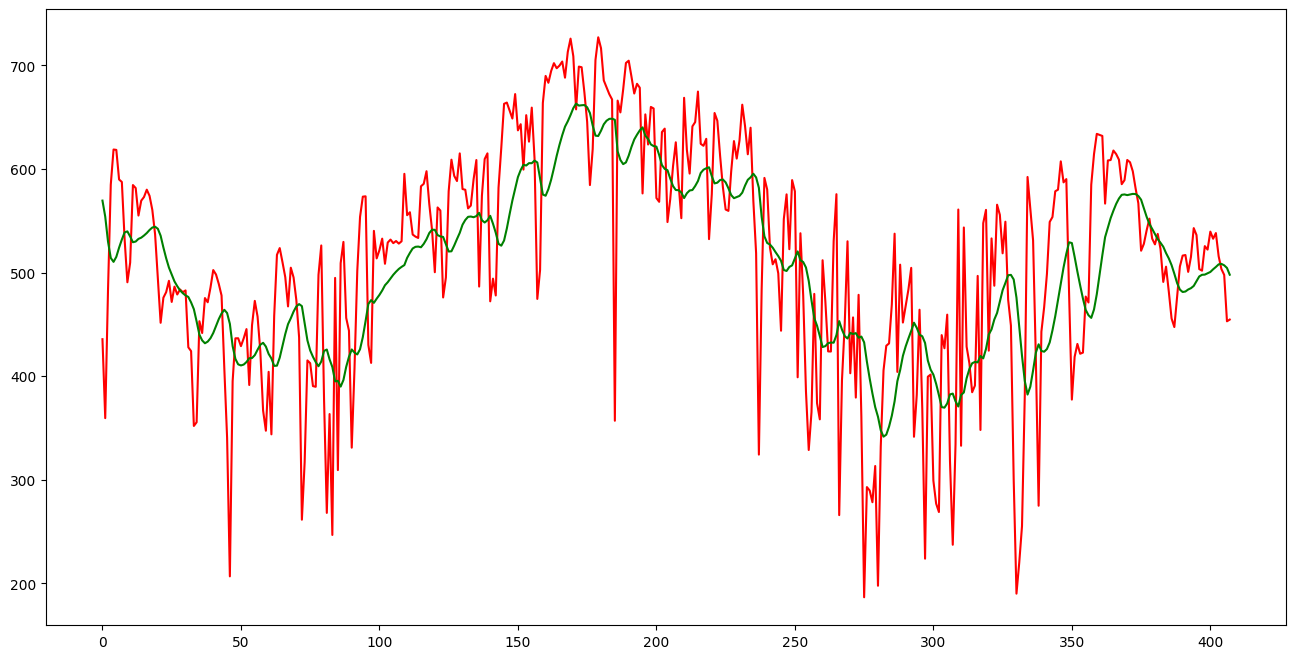

In [23]:
y_pred = model.predict(testX)

original_cases = scaler.inverse_transform(testY).flatten()
forecasted_cases = scaler.inverse_transform(y_pred).flatten()

plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(original_cases, color='red', label = 'Real GHI')
plt.plot(forecasted_cases, color='green', label = 'Predicted GHI')
plt.show()

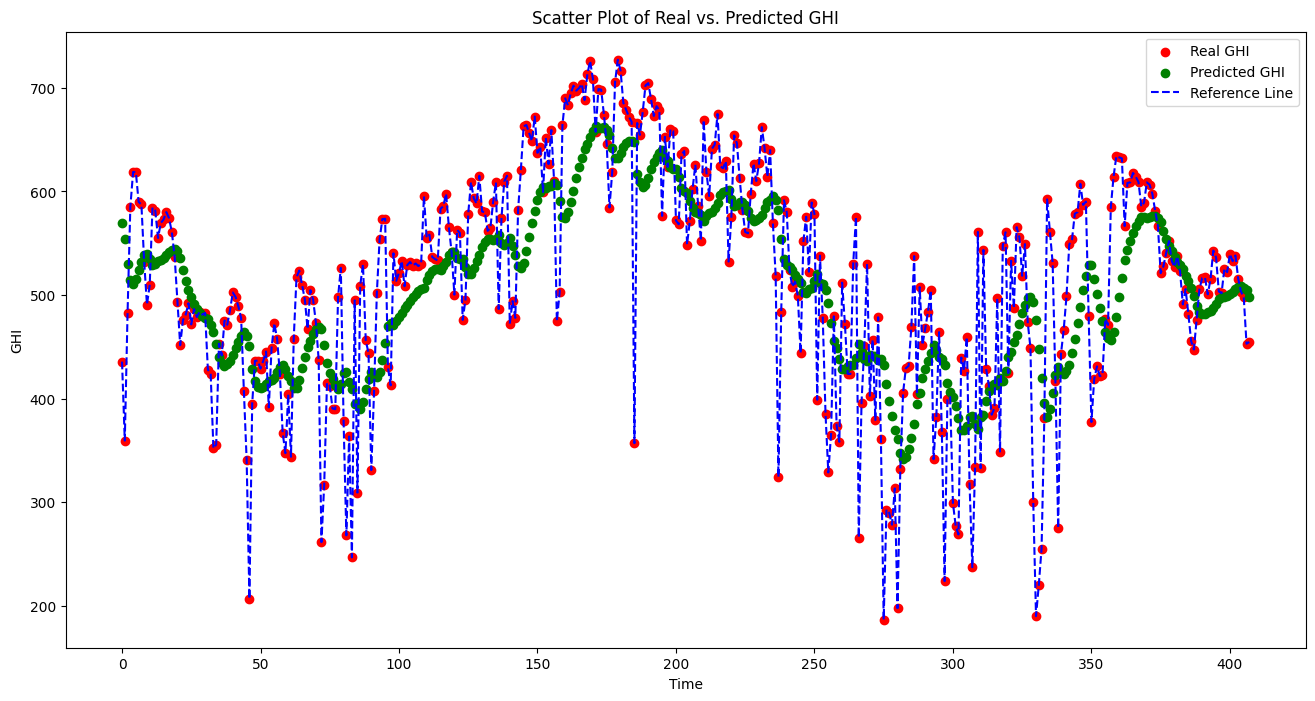

In [25]:
import matplotlib.pyplot as plt

# Assuming original values are in original_cases and forecasted values are in forecasted_cases

plt.figure(figsize=(16, 8), dpi=100, facecolor='w', edgecolor='k')

plt.scatter(range(len(original_cases)), original_cases, color='red', label='Real GHI')
plt.scatter(range(len(forecasted_cases)), forecasted_cases, color='green', label='Predicted GHI')
plt.plot(range(len(original_cases)), original_cases, color='blue', linestyle='--', label='Reference Line')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('GHI')
plt.title('Scatter Plot of Real vs. Predicted GHI')

# Add a legend
plt.legend()

# Display the plot
plt.show()
